In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
from fastai2.vision.all import show_image, show_images
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F

from htools import *
from img_wang.data import get_databunch
from img_wang.models import SingleInputBinaryModel, TorchvisionEncoder,\
    load_encoder
from img_wang.torch_utils import gpu_setup

In [5]:
cd_root()
gpu_setup()

Current directory: /storage/img-wang
Setting seeds for reproducible training.


In [60]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/', 
                                   mode='supervised',
                                   bs=64)

In [61]:
net = SingleInputBinaryModel(
    TorchvisionEncoder('mobilenet_v2', pretrained=False),
    n_out=len(dst.class_to_idx)
)

In [38]:
*xb, yb = next(iter(dlt))

In [41]:
y_proba = net.predict(*xb)
print(y_proba.shape)
y_proba[:5]

torch.Size([64, 20])


tensor([[ 5.6310e-05,  9.7185e-04, -7.3148e-05, -4.1077e-04, -7.4564e-04,
          8.7987e-04,  1.0595e-03,  3.0523e-04,  5.4420e-05, -1.1142e-03,
         -2.6826e-04,  7.0704e-04,  5.3600e-05, -5.0629e-04,  5.9594e-04,
         -4.0531e-04, -1.1877e-05,  3.2480e-04, -2.5789e-04, -3.9174e-04],
        [ 5.6310e-05,  9.7185e-04, -7.3148e-05, -4.1077e-04, -7.4564e-04,
          8.7987e-04,  1.0595e-03,  3.0523e-04,  5.4420e-05, -1.1142e-03,
         -2.6826e-04,  7.0704e-04,  5.3600e-05, -5.0629e-04,  5.9594e-04,
         -4.0531e-04, -1.1878e-05,  3.2480e-04, -2.5789e-04, -3.9174e-04],
        [ 5.6310e-05,  9.7185e-04, -7.3147e-05, -4.1077e-04, -7.4564e-04,
          8.7987e-04,  1.0595e-03,  3.0523e-04,  5.4421e-05, -1.1142e-03,
         -2.6825e-04,  7.0704e-04,  5.3600e-05, -5.0629e-04,  5.9594e-04,
         -4.0531e-04, -1.1877e-05,  3.2480e-04, -2.5789e-04, -3.9174e-04],
        [ 5.6310e-05,  9.7185e-04, -7.3148e-05, -4.1077e-04, -7.4564e-04,
          8.7987e-04,  1.0595e-03, 

In [42]:
F.cross_entropy(y_proba, yb)

tensor(2.9957)

In [81]:
state = torch.load('data/supervised_models/v10/trainer.pkl')
net.load_state_dict(state['model'])

<All keys matched successfully>

In [82]:
y_proba = net.predict(*xb)

In [107]:
post_act = F.softmax(y_proba, -1)
y_max_proba = post_act.max(-1)[0].cpu().numpy()
y_pred = post_act.argmax(-1).cpu().numpy()

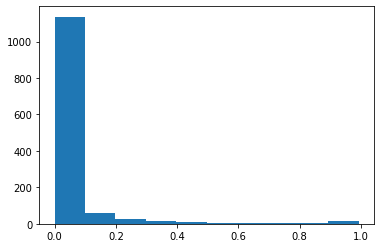

In [102]:
plt.hist(post_act.flatten())
plt.show()

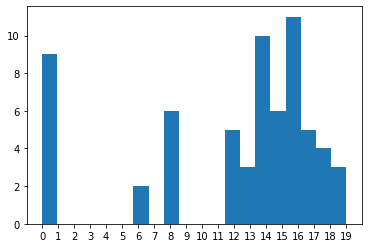

In [100]:
plt.hist(y_pred, bins=20)
plt.xticks(range(20))
plt.show()

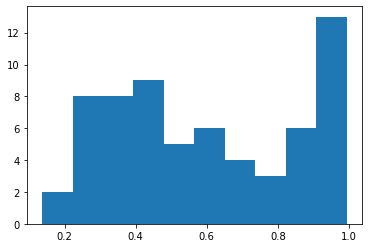

In [103]:
plt.hist(y_max_proba)
plt.show()

In [104]:
F.cross_entropy(y_proba, yb)

tensor(1.0515)

In [109]:
y_max_proba[:16]

array([0.8507495 , 0.7923822 , 0.13677101, 0.38849327, 0.40719497,
       0.5409363 , 0.41701242, 0.39532074, 0.28730392, 0.8489604 ,
       0.37250027, 0.88261884, 0.5610514 , 0.36142278, 0.28880545,
       0.9103267 ], dtype=float32)

In [110]:
y_pred[:16]

array([12, 16, 15, 16, 18, 16, 14, 14, 15,  0, 15, 16, 14,  8, 17,  8])

In [117]:
titles = [f'label={lbl.item()}, pred={pred}\nprob={prob:.3f}' 
          for lbl, pred, prob in zip(yb, y_pred, y_max_proba)]

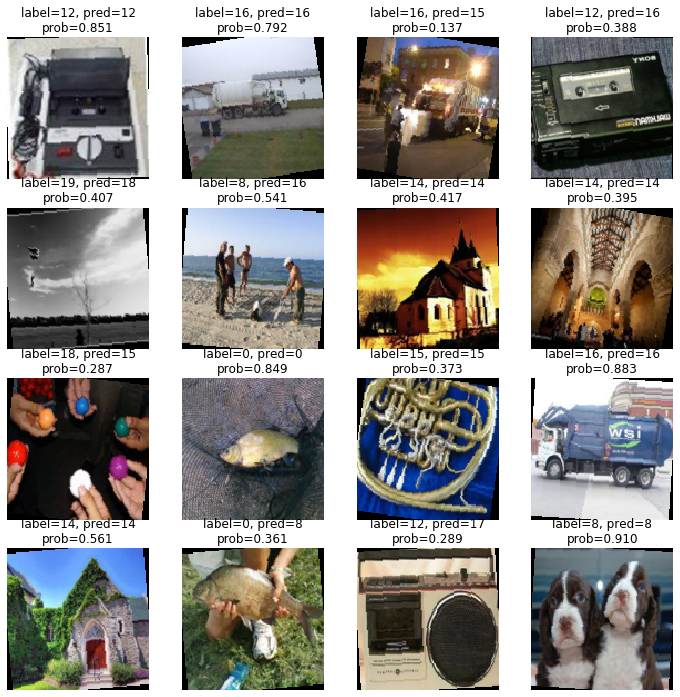

In [118]:
show_images(xb[0][:16], nrows=4, titles=titles[:16])

## Validation set

In [119]:
*xv, yv = next(iter(dlv))

In [120]:
yv_proba = net.predict(*xv)

In [121]:
post_act_v = F.softmax(yv_proba, -1)
yv_max_proba = post_act_v.max(-1)[0].cpu().numpy()
yv_pred = post_act_v.argmax(-1).cpu().numpy()

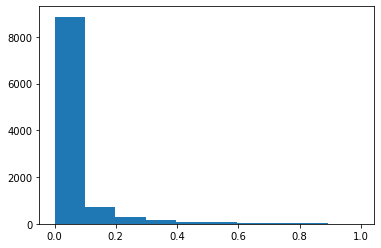

In [123]:
plt.hist(post_act_v.flatten())
plt.show()

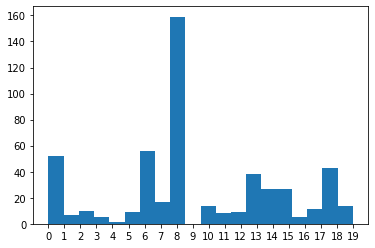

In [124]:
plt.hist(yv_pred, bins=20)
plt.xticks(range(20))
plt.show()

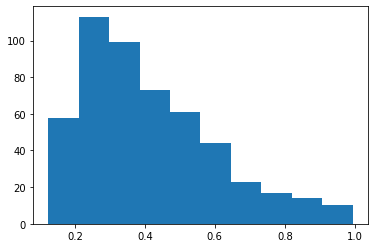

In [125]:
plt.hist(yv_max_proba)
plt.show()

In [126]:
F.cross_entropy(yv_proba, yv)

tensor(3.6513)

In [127]:
yv_max_proba[:16]

array([0.7606637 , 0.40893874, 0.3348374 , 0.21964832, 0.86023474,
       0.57707256, 0.28707218, 0.23106742, 0.36852834, 0.19176306,
       0.7927829 , 0.2603536 , 0.33567423, 0.41147143, 0.41503724,
       0.5141168 ], dtype=float32)

In [128]:
yv_pred[:16]

array([14,  8,  0, 13,  8,  8,  8,  6, 12,  8,  8,  3, 18,  0,  8,  6])

In [129]:
titles_v = [f'label={lbl.item()}, pred={pred}\nprob={prob:.3f}' 
            for lbl, pred, prob in zip(yv, yv_pred, yv_max_proba)]

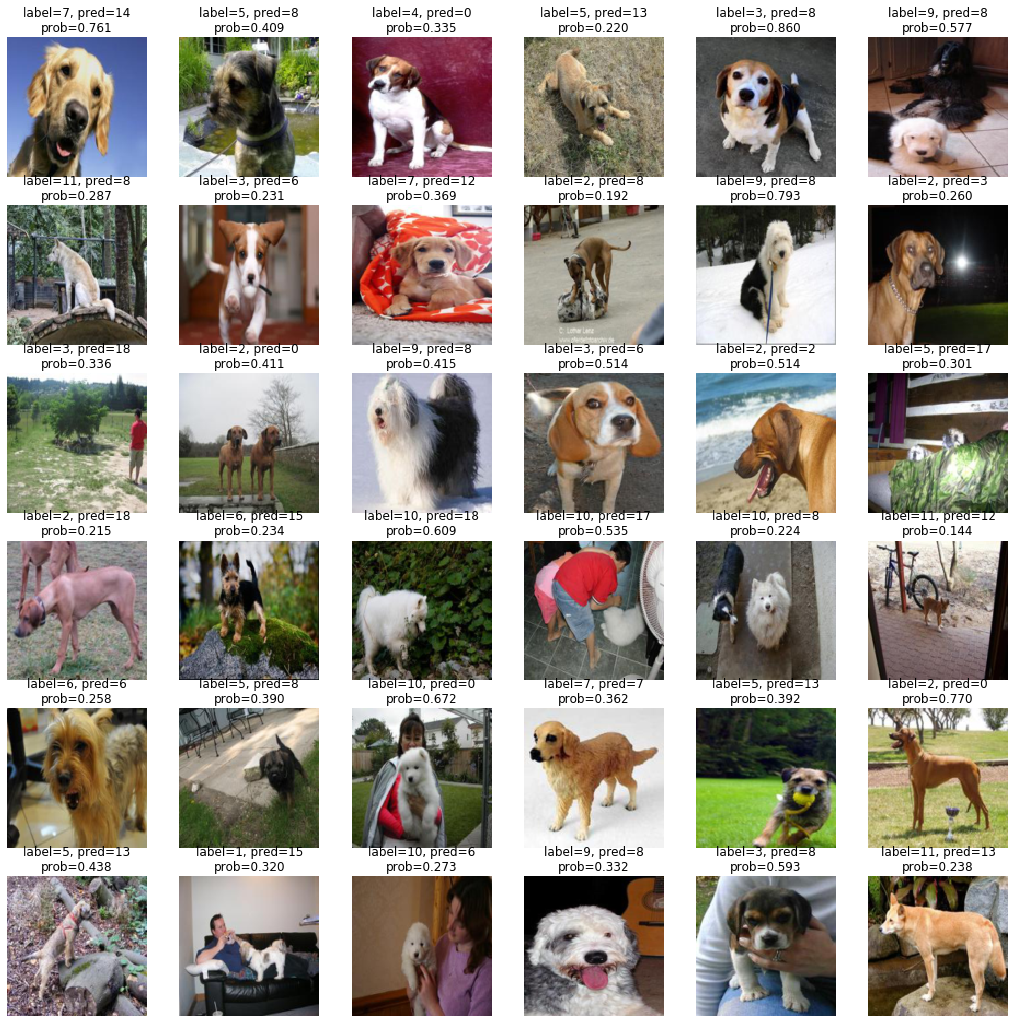

In [131]:
show_images(xv[0][:36], nrows=6, titles=titles_v[:36])